In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import optuna
from optuna.trial import Trial

In [2]:
# Load X_model.csv and print out column names
X_model = pd.read_csv('../data/X_model.csv')
print(X_model.columns)
# Load Y_model.csv and print out column names
Y_model = pd.read_csv('../data/Y_model.csv')
print(Y_model.columns)

Index(['gender', 'age_code', 'region_code', 'c20220101', 'c20220102',
       'c20220103', 'c20220104', 'c20220105', 'c20220106', 'c20220107',
       ...
       't20220817', 't20220818', 't20220819', 't20220820', 't20220821',
       't20220822', 't20220823', 't20220824', 't20220825', 't20220826'],
      dtype='object', length=717)
Index(['business'], dtype='object')


In [3]:
# Head up X_model
print(X_model.head())
# Head up Y_model
print(Y_model.head())

   gender  age_code  region_code  c20220101  c20220102  c20220103  c20220104  \
0       1        13            7        NaN        NaN        NaN        NaN   
1       1         5            1        NaN        NaN        NaN        NaN   
2       2         6            2        NaN        NaN        NaN        NaN   
3       2         1            1        NaN        NaN        NaN        NaN   
4       2         5            1        NaN        NaN        NaN        NaN   

   c20220105  c20220106  c20220107  ...  t20220817  t20220818  t20220819  \
0        NaN        NaN        NaN  ...        NaN        NaN        NaN   
1        1.0        NaN        NaN  ...        NaN        NaN        NaN   
2        NaN        NaN        NaN  ...        NaN        NaN        NaN   
3        NaN        NaN        NaN  ...        NaN        NaN        NaN   
4        NaN        NaN        NaN  ...        NaN        NaN        NaN   

   t20220820  t20220821  t20220822  t20220823  t20220824  t202

In [4]:
# Fill NaN in X_model with 0
X_model = X_model.fillna(0)

<AxesSubplot:xlabel='business', ylabel='count'>

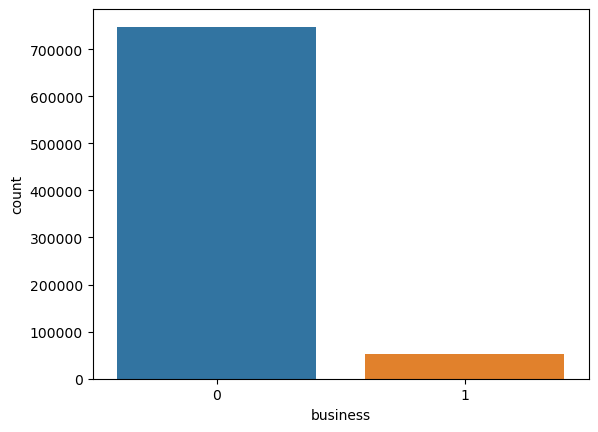

In [5]:
# Check the imbalance of train data and plot it with sns
import seaborn as sns
sns.countplot(x='business', data=Y_model)

In [7]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_model, Y_model, test_size=0.2, random_state=100)

# Task: Hyperparameter tuning with Optuna
def optimize(trial: Trial):
    # Construct a DecisionTreeClassifier object
    classifier = DecisionTreeClassifier(
        criterion="gini",
        splitter=trial.suggest_categorical('splitter', ['best', 'random']),
        max_depth=trial.suggest_int('max_depth', 1, 10),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 40),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20),
        min_weight_fraction_leaf=trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5),
        random_state=100,
        min_impurity_decrease=trial.suggest_float('min_impurity_decrease', 0.0, 0.5),
        class_weight="balanced", # Super imbalanced data
    )

    # Fit the model
    classifier.fit(X_train, y_train)

    # Predict the test data
    # y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)

    # Calculate the roc_auc_score
    roc_value = roc_auc_score(y_test, y_pred_proba[:,1])

    return roc_value

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(optimize, show_progress_bar=True, n_trials=100)

# Print the best parameters
print(study.best_params)

/Users/hwanghyeongyu/miniforge3/envs/ai_learning/lib/python3.9/site-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

{'splitter': 'best', 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 14, 'min_weight_fraction_leaf': 0.02803945023880025, 'min_impurity_decrease': 0.005005239944220596}


In [8]:
classifier = DecisionTreeClassifier(
    criterion="gini",
    splitter=study.best_params['splitter'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    min_weight_fraction_leaf=study.best_params['min_weight_fraction_leaf'],
    random_state=100,
    min_impurity_decrease=study.best_params['min_impurity_decrease'],
    class_weight="balanced", # Super imbalanced data
)

X_train, X_test, y_train, y_test = train_test_split(X_model, Y_model, test_size=0.2, random_state=100)

# Fit the model
classifier.fit(X_train, y_train)

# Predict the test data
# y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)

# Calculate the roc_auc_score
roc_value = roc_auc_score(y_test, y_pred_proba[:,1])

# Print the roc_auc_score
print("ROC AUC score: ", roc_value)

ROC AUC score:  0.7681619400975984
